#4-13. 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!


## 1. data 및 모듈 불러오기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import scipy.stats as sp

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 04/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 04/data/train.csv
/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 04/data/test.csv


In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))
data.head()

train data dim : (15035, 21)
sub data dim : (6468, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


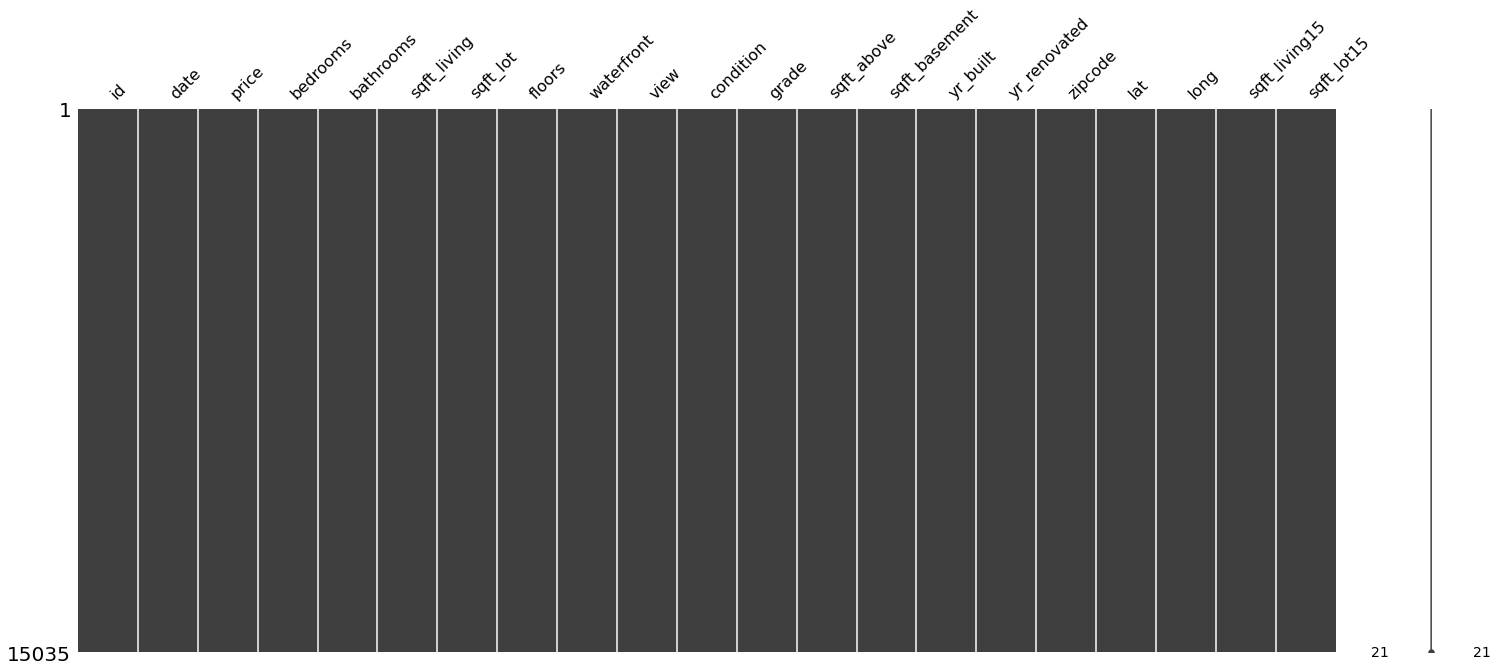

In [4]:
msno.matrix(data) # 결측치는 없음

for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

- data 와 test 를 합쳐서 전처리 과정을 진행한다. 

- id 컬럼 제거
- date T 이후 0 제거 필요
- price 칼럼은 따로 y 변수에 저장후 칼럼 제거

In [5]:
train_len = len(data) # 추후 학습데이터만 불러오기 위한 인덱스는 저장
data = pd.concat((data, sub), axis=0)

In [6]:
# id 컬럼은 index 와 겹치므로 제거
sub_id = data['id'][train_len:] # 예측 결과 제출 대비 id 칼럼은 저장
data = data.drop(['id'], axis=1)

In [7]:
# date T이후 자르기

data['date'] = data['date'].apply(lambda x : str(x[:6]))


In [8]:
y = data['price']
del data['price']


In [9]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. Data 이해하기

- 집 값의 분포 확인해봄.

Text(0.5, 1.0, 'House price distribution')

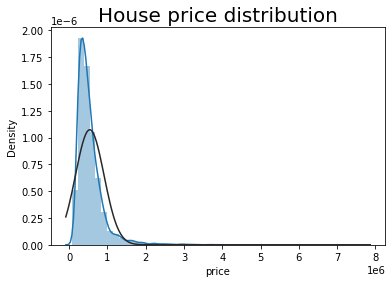

In [10]:
sns.distplot(y, fit = sp.norm)
plt.title("House price distribution", fontsize=20)

- 데이터가 오른쪽으로 꼬리가 긴것을 확인할 수 있음. 
- 정규분포화 함

In [11]:
y = np.log1p(y)

Text(0.5, 1.0, 'House price distribution')

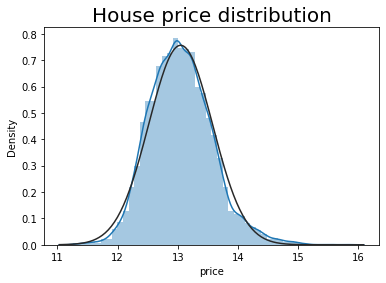

In [12]:
sns.distplot(y, fit = sp.norm)
plt.title("House price distribution", fontsize=20)

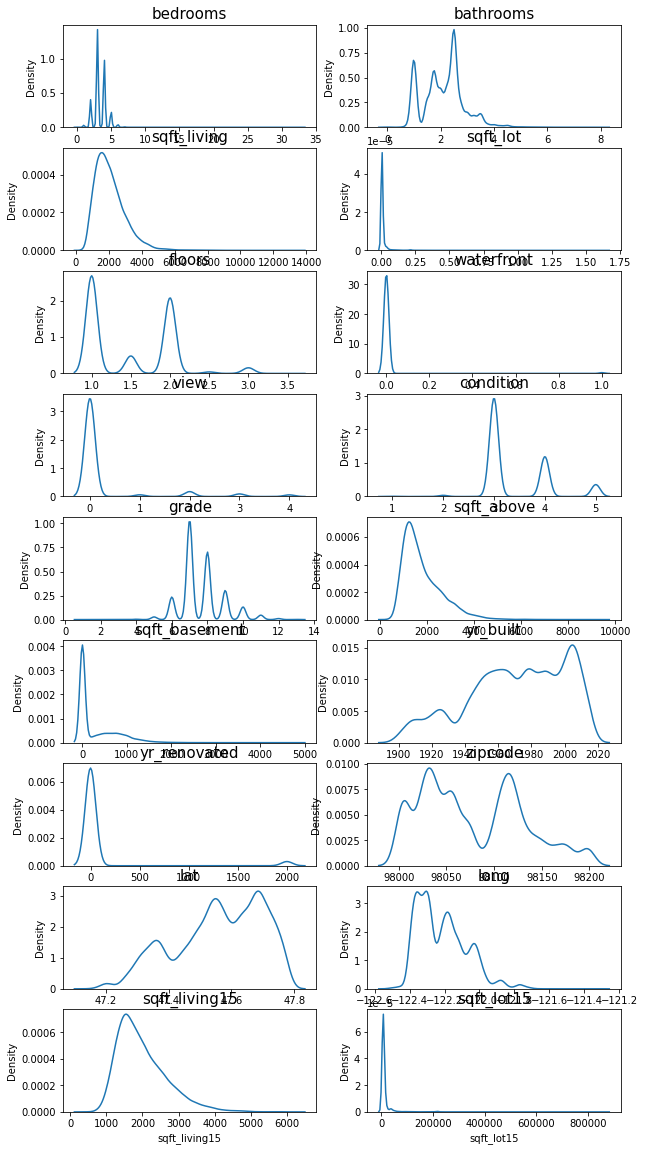

In [13]:
fig, ax = plt.subplots(9, 2, figsize=(10, 20))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [14]:
# 치우친 데이터를 로그 변환을 통해 데이터 분포를 정규 분포화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

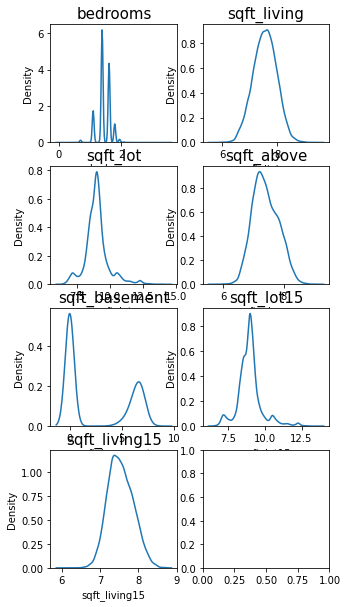

In [15]:
# 데이터 확인 
fig, ax = plt.subplots(4, 2, figsize=(5, 10))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

- data 이상치 확인

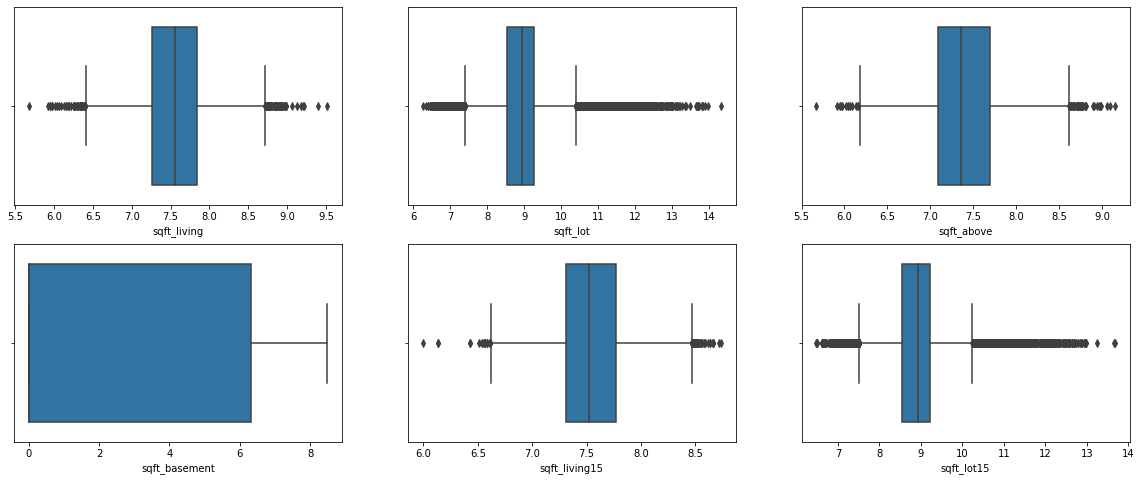

In [16]:
# 이상치 확인 

plt.figure(figsize=(20,8))
plt.subplot(231)
sns.boxplot(x=data.sqft_living)

plt.subplot(232)
sns.boxplot(x=data.sqft_lot)

plt.subplot(233)
sns.boxplot(x=data.sqft_above)

plt.subplot(234)
sns.boxplot(x=data.sqft_basement)

plt.subplot(235)
sns.boxplot(x=data.sqft_living15)

plt.subplot(236)
sns.boxplot(x=data.sqft_lot15)

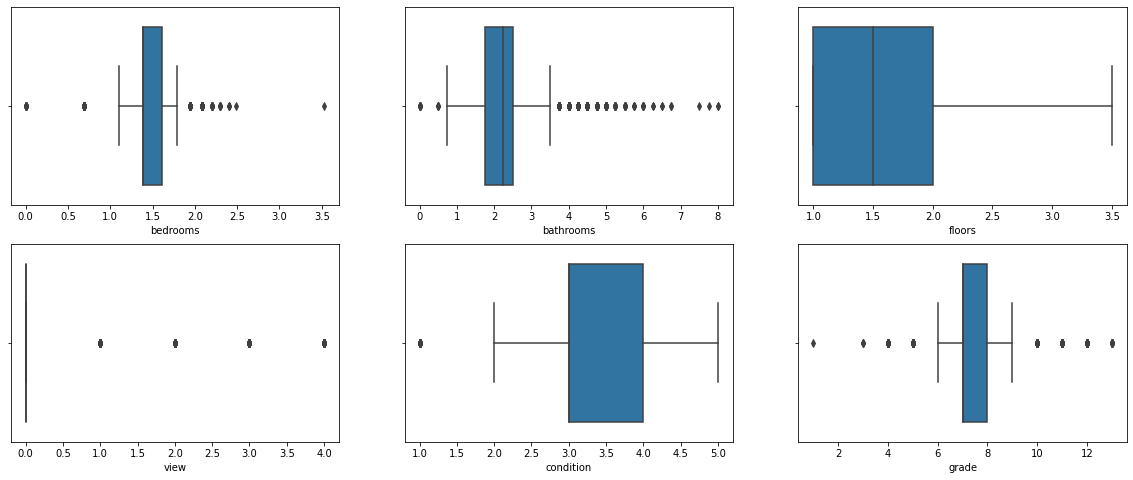

In [17]:
plt.figure(figsize=(20,8))

plt.subplot(231)
sns.boxplot(x=data.bedrooms)

plt.subplot(232)
sns.boxplot(x=data.bathrooms)

plt.subplot(233)
sns.boxplot(x=data.floors)

plt.subplot(234)
sns.boxplot(x=data.view)

plt.subplot(235)
sns.boxplot(x=data.condition)

plt.subplot(236)
sns.boxplot(x=data.grade)

In [18]:
def outlier_iqr(data, column): 

    # lower, upper 글로벌 변수 선언하기     
    global lower, upper    
    
    # 4분위수 기준 지정하기     
    q1, q3 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    
    # IQR 계산하기     
    iqr = q3 - q1    
    
    # outlier cutoff 계산하기     
    cut_off = iqr * 1.5          
    
    # lower와 upper bound 값 구하기     
    lower, upper = q1 - cut_off, q3 + cut_off     
    
    print('IQR은',iqr, '이다.')     
    print('lower bound 값은', lower, '이다.')     
    print('upper bound 값은', upper, '이다.')    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기     
    data1 = data[data[column] > upper]     
    data2 = data[data[column] < lower]    
    
    # 이상치 총 개수 구하기
    return print('총 이상치 개수는', data1.shape[0] + data2.shape[0], '이다.')

In [19]:
outlier_iqr(data,'sqft_living')

IQR은 0.5781119385853604 이다.
lower bound 값은 6.39896087167841 이다.
upper bound 값은 8.711408626019852 이다.
총 이상치 개수는 118 이다.


In [20]:
# 데이터 추가


# 방의 전체 갯수 
data['total_rooms'] = data['bedrooms'] + data['bathrooms']

# 재건축 여부 
data['is_renovated'] = data['yr_renovated'] - data['yr_built']
data['is_renovated'] = data['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
data['date'] = data['date'].astype('int')


In [37]:
data.keys().sort

<bound method Index.sort of Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'is_renovated',
       'zipcode_mean', 'zipcode_var'],
      dtype='object')>

In [38]:
sub_x = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]
sub_y = y.iloc[train_len:]
y = y.iloc[:train_len]

print(x.shape)
print(sub_x.shape)
print(y.shape)
print(sub_y.shape)

(15035, 23)
(6468, 23)
(15035,)
(6468,)


## 3. 모델 설계

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

- RMSE 계산

In [40]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

- XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델 가져오기

In [57]:
random_state = 10

gboost = GradientBoostingRegressor(random_state = random_state)
xgboost = xgb.XGBRegressor(random_state = random_state)
lightgbm = lgb.LGBMRegressor(random_state = random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [42]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(
            x, y, random_state=random_state,
            test_size = 0.2
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_pred, y_test)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df


In [44]:
for i in range(10,20):
  random_state = i
  print(i, get_scores(models, x, y))


[11:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
10                                     RMSE
RandomForestRegressor      124034.074274
XGBRegressor               119324.439081
GradientBoostingRegressor  118999.677767
LGBMRegressor              103826.717882
[11:28:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
11                                     RMSE
XGBRegressor               129918.211710
GradientBoostingRegressor  125784.135115
RandomForestRegressor      116641.995785
LGBMRegressor              107771.322778
[11:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
12                                     RMSE
XGBRegressor               151724.492671
GradientBoostingRegressor  149088.666920
RandomForestRegressor      132647.154556
LGBMRegressor              128323.88

In [46]:
get_scores(models, x, y)

[11:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
RandomForestRegressor,123430.129203
XGBRegressor,119324.439081
GradientBoostingRegressor,118954.930571
LGBMRegressor,103826.717882


## 4. 하이퍼 파라미터 튜닝. 그리드 탐색

In [47]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, data, y, param_grid, verbose=2, n_jobs=5):
  # 모델 초기화
    grid_model = GridSearchCV(model, param_grid= param_grid, 
                              scoring= 'neg_mean_squared_error',
                              cv=5,
                              verbose = verbose,
                              n_jobs= n_jobs)
  
  # fitting
    grid_model.fit(data, y)
  
  # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
  
  #데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
  
  # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1*results['score'])
    results = results.sort_values('RMSLE')
  
    return results

In [48]:
from lightgbm import LGBMRegressor, LGBMClassifier, Booster

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 5, 10],
    'learning_rate' : [0.001, 0.01, 0.1],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(x, y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=10), n_jobs=5,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [1, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [49]:
params = grid_model.cv_results_['params']
params

[{'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 50},
 {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 100},
 {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 200},
 {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 50},
 {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 100},
 {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 200},
 {'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 50},
 {'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 100},
 {'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 200},
 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50},
 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100},
 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 200},
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50},
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100},
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200},
 {'learning_rate': 0.01, 'max_depth': 10, 'n_est

In [50]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.27000114, -0.26214554, -0.24723924, -0.25829927, -0.2399497 ,
       -0.20816306, -0.25803527, -0.23938464, -0.20707587, -0.20969693,
       -0.16604514, -0.11887778, -0.14080834, -0.08370976, -0.04662331,
       -0.13865942, -0.08106988, -0.04379887, -0.07326147, -0.05481751,
       -0.04502649, -0.03144479, -0.02857194, -0.02699604, -0.02917937,
       -0.02709582, -0.02635802])

In [51]:
results = pd.DataFrame(params)
results['score'] = score
results['RMSLE'] = np.sqrt(-1 * results['score'])
results.sort_values('RMSLE')


,learning_rate,max_depth,n_estimators,score,RMSLE
26,0.100,10,200,-0.026358,0.162352
23,0.100,5,200,-0.026996,0.164305
25,0.100,10,100,-0.027096,0.164608
22,0.100,5,100,-0.028572,0.169032
24,0.100,10,50,-0.029179,0.170820
21,0.100,5,50,-0.031445,0.177327
17,0.010,10,200,-0.043799,0.209282
20,0.100,1,200,-0.045026,0.212194
14,0.010,5,200,-0.046623,0.215924
19,0.100,1,100,-0.054818,0.234131


## 5. 제출하기

In [52]:
model = LGBMRegressor(learning_rate = 0.1, max_depth=10, n_estimators=200, random_state=random_state)
model.fit(x, y)
prediction = model.predict(sub_x)
prediction = np.expm1(prediction)
prediction

array([ 491233.10410878,  504830.7553523 , 1477457.8945877 , ...,
        473199.17348776,  332518.58980576,  436129.1580789 ])

In [53]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [55]:
save_submission(model, x, y, sub_x, 'lgbm', rmsle='0.16231')

/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 04/data/submission_lgbm_RMSLE_0.16231.csv saved!


Light GBM 사용 
learning_rate = 0.1, max_depth=10, n_estimators=200, random_state=10

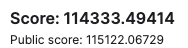

In [62]:
from sklearn.model_selection import RandomizedSearchCV

def my_RandomSearch(model, train, y, param, n_iter= 5, verbose=1, n_jobs=5):
  
    # 1. GridSearchCV 모델로 `model`을 초기화
    random_model = RandomizedSearchCV(model, param_distributions=param, \
                        scoring='neg_mean_squared_error', \
                              n_iter =  n_iter, \
                        cv=10, verbose=1, n_jobs=-1)
    
    # 2. 모델을 fitting
    random_model.fit(train, y)
    
    # 3. params, score에 각 조합에 대한 결과를 저장
    params = random_model.cv_results_['params']
    score = random_model.cv_results_['mean_test_score']
    
    # 4. 데이터 프레임을 생성
    results = pd.DataFrame(params)
    results["score"] = score
    
    # 5. RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    
    results = results.sort_values("RMSLE")
    return results

In [65]:
param = {
    'n_estimators': [int(x) for x in range(370,390,2)],
    'max_depth': [int(x) for x in range(8,10)],
}
n_iter = 100

model = LGBMRegressor(learning_rate = 0.1, max_depth=10, n_estimators=200, random_state=random_state)
my_RandomSearch(model, x, y, param, n_iter, verbose=1)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


,n_estimators,max_depth,score,RMSLE
10,370,9,-0.025881,0.160876
11,372,9,-0.025885,0.160888
9,388,8,-0.025887,0.160893
2,374,8,-0.025888,0.160898
8,386,8,-0.025889,0.160901
7,384,8,-0.025892,0.160910
3,376,8,-0.025892,0.160911
13,376,9,-0.025893,0.160912
12,374,9,-0.025894,0.160917
1,372,8,-0.025897,0.160924


In [67]:
param = {
    'n_estimators': [int(x) for x in range(100,1000,10)],
    'max_depth': [int(x) for x in range(5,20,5)],
}
n_iter = 100

model = LGBMRegressor(learning_rate = 0.1, max_depth=10, n_estimators=200, random_state=random_state)
my_RandomSearch(model, x, y, param, n_iter, verbose=1)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,n_estimators,max_depth,score,RMSLE
22,380,10,-0.025783,0.160570
68,350,10,-0.025794,0.160607
90,360,10,-0.025799,0.160621
97,330,10,-0.025812,0.160662
32,300,10,-0.025846,0.160766
...,...,...,...,...
46,110,10,-0.026774,0.163626
89,180,5,-0.027221,0.164988
1,150,5,-0.027532,0.165929
13,140,5,-0.027652,0.166290


In [72]:
model = LGBMRegressor(n_estimators=380, learning_rate = 0.1, max_depth=10, random_state=random_state)
model.fit(x, y)
prediction = model.predict(sub_x)
prediction = np.expm1(prediction)
prediction

array([ 504023.2114756 ,  517684.07014949, 1499177.45959869, ...,
        477018.81451046,  331215.8350166 ,  455273.38389104])

In [73]:
save_submission(model, x, y, sub_x, 'lgbm', rmsle='0.1605')

/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 04/data/submission_lgbm_RMSLE_0.1605.csv saved!


- 걸린 시간에 비해서 파라미터 조절로는 큰 효과를 보지 못했다.


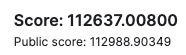

In [74]:
Lgbm_prediction = model.predict(sub_x)

회고


In [88]:
import xgboost 

regressor = xgboost.XGBRegressor(colsample_bytree = 0.4603, learning_rate = 0.06, min_child_weight = 1.8, max_depth= 3, subsample = 0.52, n_estimators = 2000, random_state= 7, ntrhead = -1) 
regressor.fit(x,y)



[13:01:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.4603, learning_rate=0.06, min_child_weight=1.8,
             n_estimators=2000, ntrhead=-1, random_state=7, subsample=0.52)

In [93]:
param = {
    'n_estimators': [int(x) for x in range(1,3000,1000)],
    'max_depth': [int(x) for x in range(1,10,5)],
}
n_iter = 50

my_RandomSearch(regressor, x, y, param, n_iter, verbose=1)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[13:14:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,n_estimators,max_depth,score,RMSLE
4,1001,6,-0.025552,0.159849
5,2001,6,-0.026012,0.161284
2,2001,1,-0.035073,0.187278
1,1001,1,-0.037108,0.192633
0,1,1,-139.396091,11.806612
3,1,6,-139.404381,11.806963


In [96]:
regressor = xgboost.XGBRegressor(colsample_bytree = 0.4603, learning_rate = 0.06, min_child_weight = 1.8, max_depth= 6, subsample = 0.52, n_estimators = 1001, random_state= 7, ntrhead = -1) 
regressor.fit(x,y)

xgb_prediction = regressor.predict(sub_x)

xgb_prediction = np.expm1(xgb_prediction)
xgb_prediction

[13:16:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([ 526163.1 ,  485788.5 , 1370157.4 , ...,  473356.84,  324074.62,
        426848.88], dtype=float32)

In [98]:
save_submission(regressor, x, y, sub_x, 'xgb', rmsle='0.1598')

[13:17:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 04/data/submission_xgb_RMSLE_0.1598.csv saved!


- 모델을 바꿔보니 조금 더 값이 떨어졌다. puplic score 는 110000점이하로 떨어졌다.

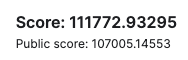

- 비율을 바꿔가면서 도전했지만 500000부터 150000까지 숫자가 안좋아지기만 했다.

In [108]:
prediction = 0.9 * Lgbm_prediction + 0.1 * xgb_prediction
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, '0.9l0.1x', '0')
submission.to_csv(submission_csv_path, index=False)
print('{} saved!'.format(submission_csv_path))

/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 04/data/submission_0.9l0.1x_RMSLE_0.csv saved!


# 회고
- 이번 노드를 진행하면서 모델들이 어떤 종류가 있고 어떻게 하이파파라미터를 튜닝하는지 공부할 수 있었다. grid search 와 random search 두 기법을 사용했는데, 시간이 오래걸렸다. 

- 단일 모델을 통한 학습은 하이퍼 파라미터를 조절해도 목표 점수에 도달하지 못했다. 검색결과 데이터 전처리 과정을 세밀하게 진행하면 단일 모델로도 목표 점수에 도달하는 사례들도 확인했지만, 전처리 과정이 부실해서인지 점수에 도달하지 못했다. 

- 다른 분들의 조언을 바탕으로 두개의 모델을 합쳐서 학습결과를 합쳐서 진행하면 목표점수에 도달할수 있다고 했다. 하지만 아직까지 원리가 이해되지는 않아서 추가 공부가 필요하다. 

- 각 모델들을 공부하고 하이퍼 파라미터를 어떻게 쓰는지 이해하는데에 생각보다 많은 시간이 들었다. 이전 노드들과는 다르게 학습자체에도 상당한 시간이 소요되어 생각보다 시간이 오래걸렸다. 후반부에는 시간관계로 노드를 진행하면서 estimator와 depth 만을 변수로 하이퍼파라미터 튜닝을 진행할 수 밖에 없어서 아쉬웠다.